In [1]:
from datetime import datetime
import os
import statsmodels.api as sm
import numpy as np
import pandas as pd
import seaborn as sns
import math
import matplotlib

In [ ]:
DATASET = os.getenv('WORKSPACE_CDR')
bucket = os.getenv('WORKSPACE_BUCKET')

In [11]:
# for C+T
array_quant = pd.read_csv(f"{bucket}/R2/array_quant.tsv",sep = "\t")
array_binary = pd.read_csv(f"{bucket}/R2/array_binary.tsv",sep = "\t")
wgs_quant = pd.read_csv(f"{bucket}/R2/wgs_quant.tsv",sep = "\t")
wgs_binary = pd.read_csv(f"{bucket}/R2/wgs_binary.tsv",sep = "\t")

In [3]:
# for PRS-CS
array_quant = pd.read_csv(f"{bucket}/R2/PRScs_array_quant.tsv",sep = "\t")
array_binary = pd.read_csv(f"{bucket}/R2/PRScs_array_binary.tsv",sep = "\t")
wgs_quant = pd.read_csv(f"{bucket}/R2/PRScs_wgs_quant.tsv",sep = "\t")
wgs_binary = pd.read_csv(f"{bucket}/R2/PRScs_wgs_binary.tsv",sep = "\t")

In [ ]:
array_quant['pheno'] = array_quant['pheno'].replace("leukocyte", "Leukocyte")
array_binary['pheno'] = array_binary['pheno'].replace({"Breast_Cancer": "Breast Cancer", "Colorectal_Cancer": "Colorectal Cancer"})

In [ ]:
wgs_quant['pheno'] = wgs_quant['pheno'].replace("leukocyte", "Leukocyte")
wgs_binary['pheno'] = wgs_binary['pheno'].replace({"Breast_Cancer": "Breast Cancer", "Colorectal_Cancer": "Colorectal Cancer"})

# Paired t test

In [20]:
from scipy.stats import ttest_rel
import pandas as pd

def perform_paired_ttest(df1, df2, phenos, ancestries, pheno_col='pheno', ancestry_col='Ancestry', r2_col='R2'):

    results = []

    # Loop through each combination of pheno and ancestry
    for pheno in phenos:
        for ancestry in ancestries:
            # Filter the data for both dataframes based on pheno and ancestry
            df1_subset = df1[(df1[pheno_col] == pheno) & (df1[ancestry_col] == ancestry)]
            df2_subset = df2[(df2[pheno_col] == pheno) & (df2[ancestry_col] == ancestry)]
            
            # Ensure that data can be paired correctly
            if not df1_subset.empty and not df2_subset.empty:
                # Align both subsets to ensure rows correspond to the same observations
                paired_data = pd.merge(
                    df1_subset[[r2_col]], 
                    df2_subset[[r2_col]], 
                    left_index=True, 
                    right_index=True, 
                    suffixes=('_df1', '_df2')
                )

                # Perform the paired t-test if there are enough paired rows
                if len(paired_data) > 1:
                    t_stat, p_value = ttest_rel(paired_data[f'{r2_col}_df1'], paired_data[f'{r2_col}_df2'], nan_policy='omit')

                    # Assign significance stars based on p-value
                    if p_value < 0.001:
                        significance = '***'
                    elif p_value < 0.01:
                        significance = '**'
                    elif p_value < 0.05:
                        significance = '*'
                    else:
                        significance = 'ns'  # Not significant

                    # Determine the direction (increase or decrease)
                    mean_r2_df1 = paired_data[f'{r2_col}_df1'].mean()
                    mean_r2_df2 = paired_data[f'{r2_col}_df2'].mean()

                    if mean_r2_df2 > mean_r2_df1:
                        direction = 'increase'  # Higher R2 in WGS than in array
                    else:
                        direction = 'decrease'  # Lower R2 in WGS than in array

                    # Append the results
                    results.append({
                        'Pheno': pheno,
                        'Ancestry': ancestry,
                        'T-statistic': t_stat,
                        'P-value': p_value,
                        'Significance': significance,
                        'Direction': direction
                    })

    # Convert results to DataFrame
    results_df = pd.DataFrame(results)
    
    return results_df

In [ ]:
results_quant = perform_paired_ttest(array_quant, wgs_quant, phenos=['Height', 'DBP', 'HDL', 'TC', 'RBC', 'Leukocyte'], ancestries=['EUR', 'AMR', 'AFR'])
results_binary = perform_paired_ttest(array_binary, wgs_binary, phenos=['Asthma', 'T2D', 'Colorectal Cancer', 'Breast Cancer'], ancestries=['EUR', 'AMR', 'AFR'])

In [23]:
results_quant.to_csv('results_quant.tsv', sep='\t', index=False)  
results_binary.to_csv('results_binary.tsv', sep='\t', index=False)  

# Bar plot

In [8]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

array_quant['Source'] = 'Array'
wgs_quant['Source'] = 'WGS'

In [9]:
# Combine the two datasets
quant_df = pd.concat([array_quant, wgs_quant])

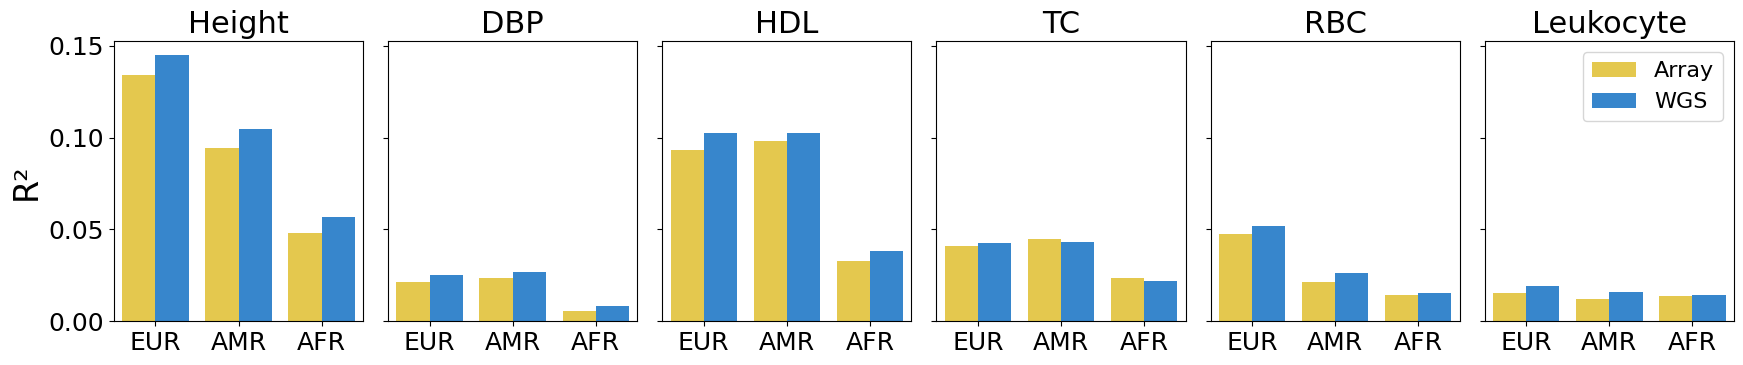

In [11]:
data = quant_df

# Unique phenotypes
phenotypes = data['pheno'].unique()

# Create subplots in one row with shared y-axis
fig, axes = plt.subplots(1, len(phenotypes), figsize=(len(phenotypes) * 3, 4), sharex=False, sharey=True)

for i, pheno in enumerate(phenotypes):
    ax = axes[i]  # Access each subplot
    subset = data[data["pheno"] == pheno]  # Filter data for the current phenotype
    
    # Create the bar plot
    sns.barplot(
        data=subset,
        x="Ancestry",
        y="R2",
        hue="Source",
        ax=ax,
        palette=["#FDD835", "#1E88E5"]  # #81C784, #1E88E5
    )
    
    ax.set_title(f"{pheno}", fontsize=22)
    ax.set_xlabel("", fontsize=18)
    if i == 0:  # Only label y-axis on the first subplot
        ax.set_ylabel("R²", fontsize=24)
    else:
        ax.set_ylabel("")  # Remove redundant y-axis labels
    
    # Increase tick label font size
    ax.tick_params(axis='both', which='major', labelsize=18)  

    # Adjust legend
    if i == len(phenotypes) - 1:  # Only show the legend on the last subplot
        ax.legend(title="", loc="upper right", fontsize=16)
    else:
        ax.get_legend().remove()  # Remove legends from other subplots


# Adjust layout to control spacing between subplots
plt.subplots_adjust(left=0.05, right=0.95, top=0.9, bottom=0.2, wspace=0.1)

# Save the figure as an SVG file
plt.savefig("array_quant_ct.svg", format="svg", dpi=300)

# Display the plot
plt.show()

In [12]:
array_binary['Source'] = 'Array'
wgs_binary['Source'] = 'WGS'

In [13]:
binary_df = pd.concat([array_binary, wgs_binary])

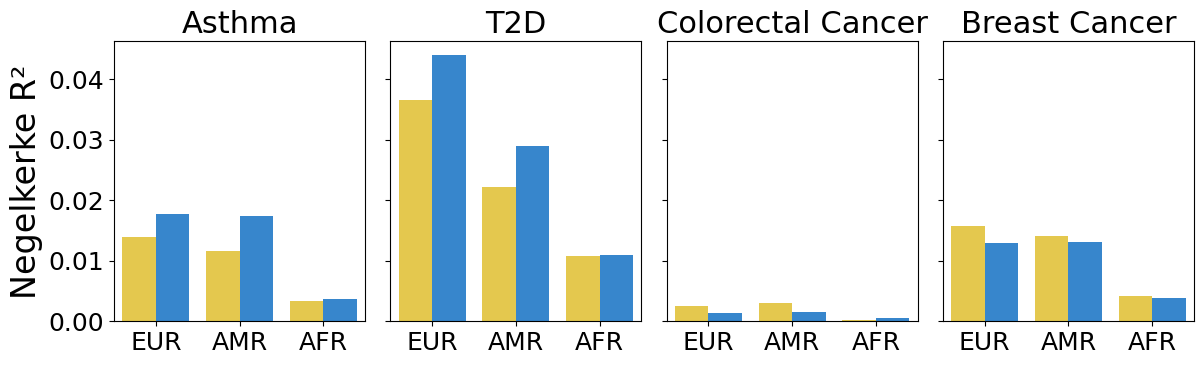

In [15]:
data = binary_df

# Unique phenotypes
phenotypes = data['pheno'].unique()

# Create subplots in one row with shared y-axis
fig, axes = plt.subplots(1, len(phenotypes), figsize=(len(phenotypes) * 3, 4), sharex=False, sharey=True)

for i, pheno in enumerate(phenotypes):
    ax = axes[i]  # Access each subplot
    subset = data[data["pheno"] == pheno]  # Filter data for the current phenotype
    
    # Create the bar plot
    sns.barplot(
        data=subset,
        x="Ancestry",
        y="R2",
        hue="Source",
        ax=ax,
        palette=["#FDD835", "#1E88E5"]  # #81C784, #1E88E5
    )
    
    ax.set_title(f"{pheno}", fontsize=22)
    ax.set_xlabel("", fontsize=18)
    if i == 0:  # Only label y-axis on the first subplot
        ax.set_ylabel("Negelkerke R²", fontsize=24)
    else:
        ax.set_ylabel("")  # Remove redundant y-axis labels
    
    # Increase tick label font size
    ax.tick_params(axis='both', which='major', labelsize=18)  

    # Remove legend
    ax.get_legend().remove()  # Remove legends from other subplots

# Adjust layout to control spacing between subplots
plt.subplots_adjust(left=0.05, right=0.95, top=0.9, bottom=0.2, wspace=0.1)

# Save the figure as an SVG file
plt.savefig("array_binary_ct.svg", format="svg", dpi=300)

# Display the plot
plt.show()